#  **Ubiquant Market Prediction**


# Data Description

https://www.kaggle.com/competitions/ubiquant-market-prediction/overview


This dataset contains features derived from real historic data from thousands of investments. Your challenge is to predict the value of an obfuscated metric relevant for making trading decisions.

This is a code competition that relies on a time-series API to ensure models do not peek forward in time. To use the API, follow the instructions on the Evaluation page. When you submit your notebook, it will be rerun on an unseen test. This is also a forecasting competition, where the final private leaderboard will be determined using data gathered after the training period closes.

Files: train.csv

***row_id*** - A unique identifier for the row.

***time_id*** - The ID code for the time the data was gathered. The time IDs are in order, but the real time between the time IDs is not constant and will likely be shorter for the final private test set than in the training set.

***investment_id*** - The ID code for an investment. Not all investment have data in all time IDs.

***\[f_0:f_299\]*** - Anonymized features generated from market data.

***target*** - The target.

# Evaluation

This is a forecasting competition with an active training phase and a second period where models will be run against real market data.


Submissions are evaluated on the mean of the Pearson correlation coefficient for each time ID.

One must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'KAGGLE/Ubiquant/'

Mounted at /content/gdrive


In [3]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats

In [ ]:
# To match Kaggle's TF/Keras versions (as I train models on Google Colab's GPUs and then submit on Kaggle)

!pip install tensorflow-gpu==2.6.2
!pip install keras==2.6.0

## Import dataset 

I use reduced precision to avoid memory issues (given the dataset size of ~3 million rows). 

i.e., data types are overrriden to

data_types_dict = {
    'time_id': 'int32',
    'investment_id': 'int16',
    "target": 'float16',
} 

In [ ]:
%%time
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle(base_dir + 'train.pkl')

There is a total of ~3m rows (len(train) = 3,141,410).

In [5]:
train.head()

,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


# Some light EDA

The dataset contains 300 anonymous (i.e. no description) features, *investment_id*, and target that is also anonymized (float) value.

The *target* values look normal without apparent outliers/heavy tails.  

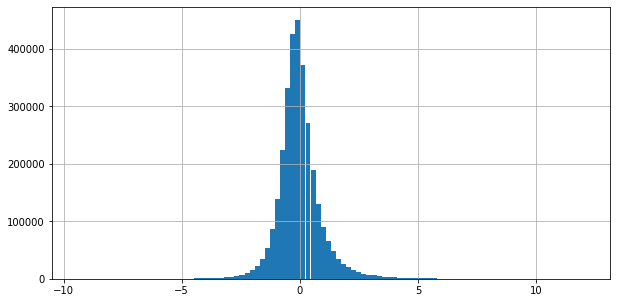

In [7]:
train['target'].hist(bins = 100, figsize = (10, 5))

In total, there are 3,500 *investment_id*s (train_df['investment_id'].nunique() = 3579).

Examine distributions of targets for a few random *investment_id*s.

Again, nothing outstanding, so no additional data transformations applied. 

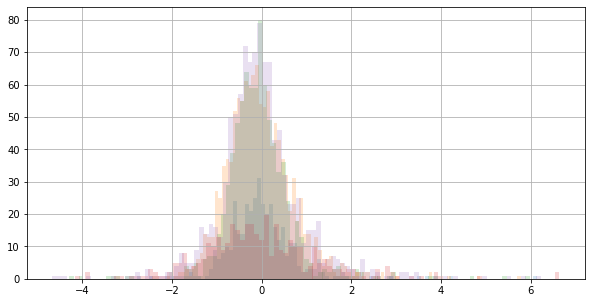

In [13]:
for f in np.random.choice(train['investment_id'].unique(), 5):
    train[train['investment_id'] == f]['target'].hist(bins = 100, alpha = 0.2, figsize = (10,5))

I have tried reducing feature set by first running LighGBM and picking the top N features by feature importance (i.e. lightgbm.plot_importance(lgbm, figsize = (30, 60))). 
But this didn't seem to help. So all 300 features were used in the final version. 



## *investment_id*

As can be seen below, the data is imbalanced with some IDs under-represented. Moreover, the test set (on which Leaderboard scores are determined)  <u> might include IDs that are not present in the training set</u>.

I therefore stratify the data by *investment_id* when doing StratifiedKFold, as well as create an OOV token (to capture unseen IDs and to group/train together IDs with insuffcient data). 

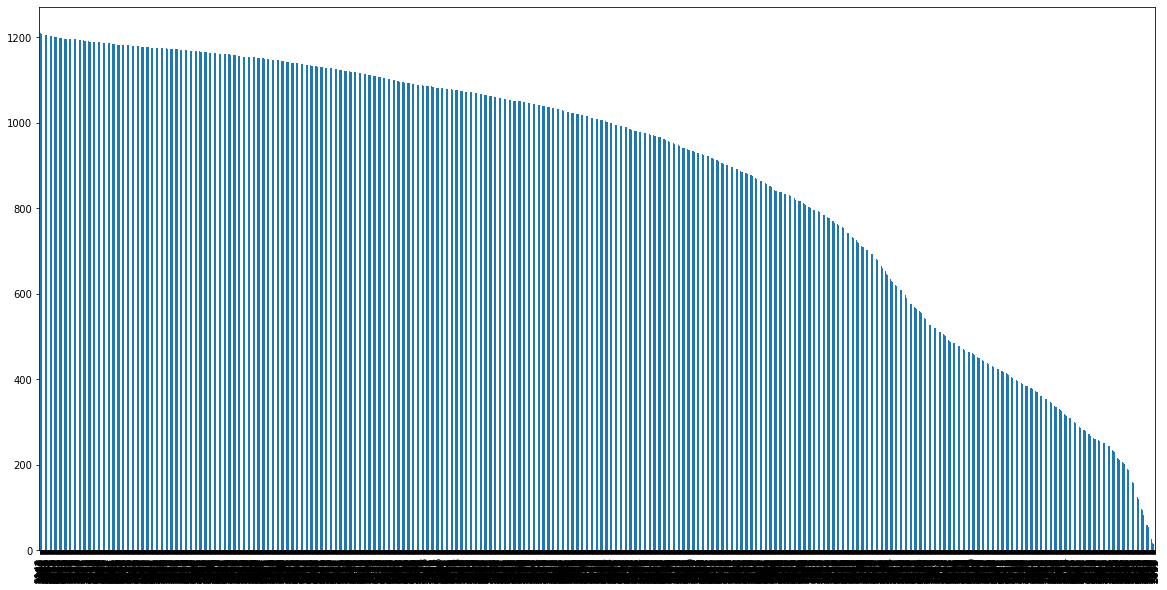

In [7]:
train['investment_id'].value_counts().plot(kind = 'bar',figsize = (20,10))

In [ ]:
investment_id = train.pop("investment_id")
investment_id.head()

# *time_id*

As most participants in this competition, I discard *time_id* given that the real time between the time IDs is not constant and will likely be shorter for the final private test set than in the training set. 
The latter makes it difficult to make use of any sequential structure in the data. 
All attempts to try RNN-like models or to use *time_id* feature in any way do not seem to help. 
In the end, the data is treated as tabular, so that most common approaches that are tried by participants are all sorts of boosting models (XGBoost/LightGBM) as well as variations of DNNs (the approach I use below).

In [ ]:
_ = train.pop("time_id")

In [ ]:
y = train.pop("target")
y.head()

0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

## Create an IntegerLookup layer for investment_id input to be used to create dense Embeddings for each ID. 

See [IntegerLookup in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup)

Since 

a.   some *investment_id*s don't have much data and

b.   the test set (unseen/Leaderboard) might include IDs that are not present in the training set,

we create an OOV-like bucket. 

In [ ]:
%%time
num_tokens = (len(list(investment_id.unique())) - 800) # 800 least frequent investmen_ids will be considered OOV and grouped together during training.
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = layers.IntegerLookup(max_tokens = num_tokens)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

## Make Tensorflow dataset

In [ ]:
import tensorflow as tf
def preprocess(X, y):
    return X, y

batch_size = 1024 * 4
shuffle = 4096 * 8
  
def make_dataset(feature, investment_id, y, batch_size = batch_size, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(shuffle)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# I have tried using correlation as a loss, since submissions are evaluated on the mean of the Pearson correlation coefficient for each time ID.
# This didn't work better than using loss = 'mse', though...

def pearson_correlation(y_true, y_pred, axis=-1):
    y_true = y_true-tf.reduce_mean(y_true)
    y_pred = y_pred-tf.reduce_mean(y_pred)
    y_true = tf.linalg.l2_normalize(y_true, axis=axis)
    y_pred = tf.linalg.l2_normalize(y_pred, axis=axis)
    return 1 - tf.reduce_sum(y_true * y_pred, axis=axis)

# See: https://www.tensorflow.org/api_docs/python/tf/keras/losses/cosine_similarity

def pearson_correlation_loss(y_true, y_pred, axis=-1):
    y_true = y_true-tf.reduce_mean(y_true)
    y_pred = y_pred-tf.reduce_mean(y_pred)
    cosine = keras.losses.cosine_similarity(y_true, y_pred, axis=axis)
    return cosine

## Model

The below is a relatively standard approach to dealing with mixed (categorical + numerical) tabular regression task of this kind. 
First, categorical feature is vectorized via an Embedding layer (OOV 'token' is used to account for unseen IDs in the test data, as well as to group together training IDs with low data count). 

Two variants are common then: Either concatenate ID embedding with 300 numerial features and process those with fully-connected layers, OR first process embedding vector with a FCNN, then process numerical features with FCNN, and then concatenate the resulting vector and proces further with a single or a few more layers, followed by the final output layer. 

I use the latter approach as it gives better results. 
See a *plot_model* diagram below. 

In [ ]:
loss = 'mse' #pearson_correlation #'mse'

def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    # Have also tried dropping out features (given a high dimensionality (300 features))
    # features_inputs_dr = layers.Dropout(0.2)(features_inputs)

    # The FCNN block below processes investment_id features
    # All non-linear layers below use 'swish' as an activation function. 
    # This activation is used often in Kaggle and it generally does seem to give better results (I've tried other variants (RELU/leaky RELU) as well).

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(num_tokens, 32, input_length = 1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.5)(investment_id_x)#, training = True)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)

    # The FCNN block below processes f_i features (i = 1, ..., 300)
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.5)(feature_x)#, training = True)
    feature_x = layers.Dense(256, activation='swish')(feature_x)

    # Concatenated and processed with a single layer
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])

    # L2 regularization usually works well on the final layer (default value for penalty l2 = 0.01)
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)

    # Output layer
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss = loss, metrics=['mse'])
    return model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_9[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 32)        88928       integer_lookup[4][0]             
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 32)           0           embedding_4[0][0]                
____________________________________________________________________________________________

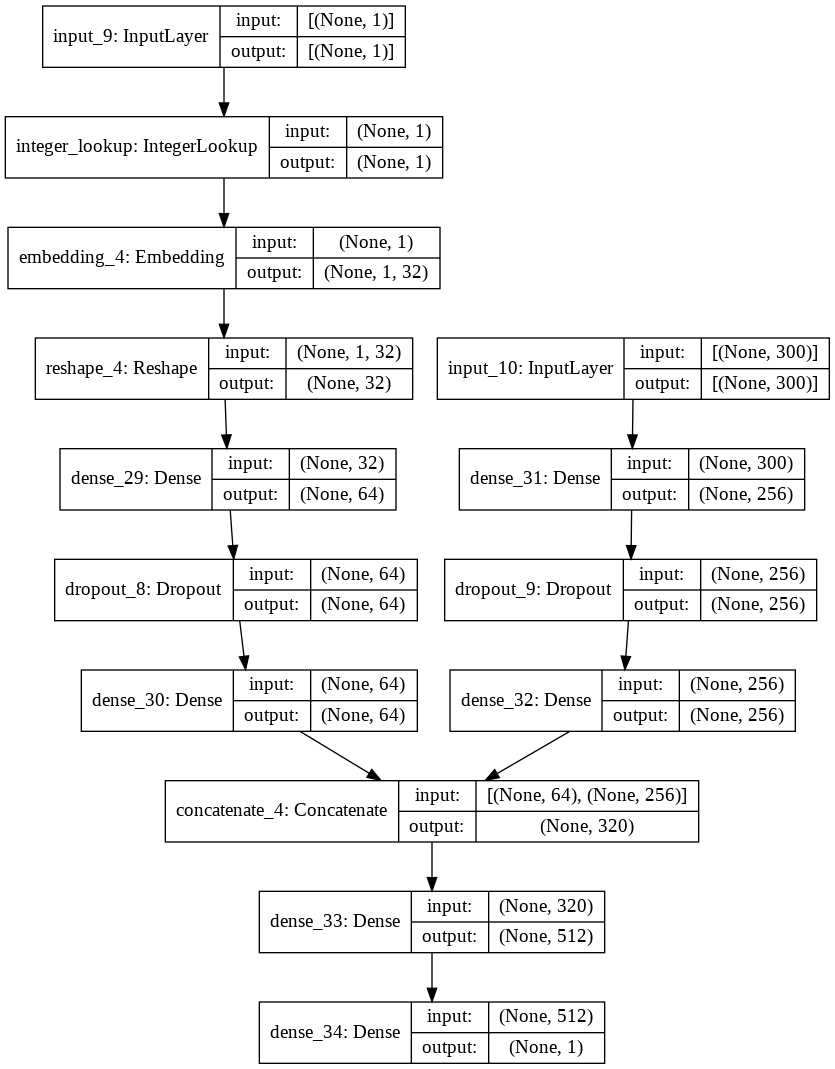

In [ ]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

# Training

I use k-fold stratified CV. Stratifying by *investmend_id*, as well as using 5 folds, gives the best results. I then train and average 5 models to use for a submission.

I have tried more sophisticated approaches, but decided not to 'abuse' the Leaderboard too much as there is a risk of overfitting (the final rankings will be based on the new/private data that will be updated bi-weekly until mid July 2022).  

In [ ]:
%%time

models = []
seeds = list(range(42, 43))

for seed in seeds:

  from sklearn.model_selection import StratifiedKFold
  kfold = StratifiedKFold(5, shuffle=True, random_state = seed)

  for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
      X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
      investment_id_train = investment_id[train_indices]
      y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
      investment_id_val = investment_id[valid_indices]
      train_ds = make_dataset(X_train, investment_id_train, y_train)
      valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
      model = get_model()
      checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
      early_stop = keras.callbacks.EarlyStopping(patience=20)
      rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience = 3, verbose=1)
      history = model.fit(train_ds, epochs=150, validation_data=valid_ds, callbacks=[checkpoint, early_stop, rlrop])
      model = keras.models.load_model(f"model_{index}")#, custom_objects={'pearson_correlation_loss' : pearson_correlation_loss, 'pearson_correlation' : pearson_correlation})
      models.append(model)
      
      pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
      print('Pearson:', pearson_score)
      #pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
      pd.DataFrame(history.history, columns=["loss", "val_loss"]).plot()
      plt.title("MSE")
      plt.show()
      #pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
      # plt.title("MAE")
      # plt.show()
      # pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
      # plt.title("RMSE")
      #plt.show()
      del investment_id_train
      del investment_id_val
      del X_train
      del X_val
      del y_train
      del y_val
      del train_ds
      del valid_ds
      gc.collect()
      # if index == 3:
      #     break

In [ ]:
for index, model in enumerate(models):
  model.save(base_dir + f'model_{index}_5Models_5Folds_OOV800_small')


## Submission

In [ ]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 